# CS5950/CS4950/CS3950 Course Project

This project recaps and systematises work that has been done in the exercise notebooks: if you have worked through the notebooks, little extra work is required.  The aim of the project is to give you the experience of trying to develop a neural network classifier (or regressor), involving setting up a model, optimising the amount of regularisation, investigating its performance, and devising a new model.

You should do your work in this notebook, filling in the sections below. To do the work, you may re-use code from ***any of the lab-session sheets provided so far***. (In fact, you should be able to do nearly the entire project using code taken from previous lab sessions.)

Please complete this workbook and submit it on Moodle together with answers for other questions, with all outputs (numbers and graphs) visible and included.

Please write your student number **here** 101008860:     
so that I have an identifier of which worksheet I am marking, to prevent any confusion! (I have to download your notebooks before marking them, so I don't want to accidentally give credit for your notebook to somebody else...)

## Set up dataset

You may choose any of the datasets included with Pytorch, or used in the course so far (including, for example, the percolation data). (It is a free country and you may use any other data you wish.)

A safe choice would be either the MNIST data or the MNIST-fashion data, which is a drop-in replacement for MNIST (same size data format, same number of classes, same number of training and test examples).

A more interesting choice would be CIFAR-10

In setting up the data, you should set up a training set and a test set. The test set should be large enough to give a reasonably accurate assessment of the error-rate (or loss) of your models: preferably at least 10,000 examples.

For the learning curve experiment (below), you will need to construct training sets of different sizes, with the largest at least 10 times the smallest. For the MNIST data, for example, your smallest training set might be 500, with sizes 500, 1000, 2000, 4000, 8000, 16000, 32000, and perhaps 60000 if you have time. (You get no extra marks for doing very long experiments.)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Subset, random_split
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.data import random_split, DataLoader, Subset
import torch
from torchvision import datasets, transforms
import numpy as np
%matplotlib inline


In [2]:
#amount dataset and ephocs

epochsDimention = 50
dataDimention = 2000
seed =42


In [3]:
########
#THIS IS THE DATASET
########


import random


def dataset(dataSize,seed):

       # Set seeds for reproducibility
    g = torch.Generator()
    g.manual_seed(seed)
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0,), (1.0,))])

        # Load full MNIST dataset
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    mnist_trainset_small =  [ train_dataset[i] for i in range(0,dataSize) ]

    mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    mnist_testset_small =[mnist_testset[i] for i in range(0,1000) ]


    train_loader = torch.utils.data.DataLoader( mnist_trainset_small, batch_size=4, shuffle=True,generator=g)
    val_loader = torch.utils.data.DataLoader( mnist_testset_small, batch_size=4, shuffle=True,generator=g)

    
    '''
    # Create data loaders
    batch_size = 64
    train_loader = DataLoader(train_indices, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_indices, batch_size=batch_size, shuffle=True)
    #test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    val_loader.data.shape()
    '''

    return train_loader, val_loader


In [4]:
dataset(dataDimention,seed)

100%|██████████| 9.91M/9.91M [00:03<00:00, 2.76MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 326kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.85MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.24MB/s]


(<torch.utils.data.dataloader.DataLoader at 0x1b6a8e88ef0>,
 <torch.utils.data.dataloader.DataLoader at 0x1b6a8ceb350>)

In [5]:
#######
#TRHIS IS Q1 LOSS
######


def lossCalculation(model,train_loader,val_loader,num_epochs,loss_Funciton,optimizer): 
    #num_epochs = 100
    train_losses, val_losses = [], []
    train_errors, val_errors = [], []
    for epoch in range(num_epochs):
        # Training
        
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_Funciton(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_losses.append(train_loss / len(train_loader))
        train_errors.append(1 - correct_train / total_train)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = loss_Funciton(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_losses.append(val_loss / len(val_loader))
        val_errors.append(1 - correct_val / total_val)
        #print(model)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Error: #{train_errors[-1]:.4f}, Val Error: {val_errors[-1]:.4f}")
    return train_losses,val_losses


In [6]:
######
#THIS IS Q2 LOSS CALCULATION
#####


def lossCalculation2(mm,train_loader,val_loader,num_epochs):  # ADD MODEL

    
    #weight_decay_values = [0, 1e-2, 1e-3, 1e-4, 1e-5]  # Experiment with different values
    weight_decay_values =[0, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1] ### change the parameter
    results = {}
    avg_val_losses = {}  # Store average validation losses
    val_error_rate_epoch = []   #store val_error for epoch
    result_val_error_wd = {}    #store val_erro for eight_decay
    #best_weight_dacay = 0

    
    #loops through differetn weight decay value
    for wd in weight_decay_values:
        #print(f"Training with weight decay = {wd}")

        # Initialize model and optimizer
        model = mm       ##GENERALIZE MODEL
        #print(model)

        #weight_decay = L2 regualrization 
        #lr = learing rate to reduce the instability

        optimizer = optim.Adam(model.parameters(),lr = 0.0005, weight_decay=wd)  # L2 regularization   ##### GENERALIZE MODEL
        #print(optimizer)

        # Define loss function
        loss_Funciton = nn.CrossEntropyLoss()
        #print("ciao",num_epochs)
        #num_epochs = 5  # Reduce for faster experimentation
        train_losses, val_losses = [], []

        for epoch in range(num_epochs):
            # Training
            model.train()      #### GENERALIZE MODEL
            train_loss = 0.0
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)   ##GENERALIZE MODEL
                loss = loss_Funciton(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            train_losses.append(train_loss / len(train_loader))

            # Validation
            model.eval()           #GENERALIZE MODEL
            val_loss = 0.0       
            correct, total = 0.0, 0.0  #inizialize correct prediction and the number of labels.
            with torch.no_grad():
                for images, labels in val_loader:
                    outputs = model(images)        #DGENERALIZE MODEL
                    loss = loss_Funciton(outputs, labels)
                    val_loss += loss.item()

                    #compute Error Rate
                    _,predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item() #count the correct prediction

            val_losses.append(val_loss / len(val_loader))
            #val_error_rate_epoch.append( 1 - (correct / total))

            #print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

        # Store results for plotting
        results[wd] = val_losses
        

        #store the error rate of each traininig size
        #result_val_error_wd[wd] = val_error_rate_epoch 

        # Compute the average validation loss over the last `last_n_epochs` epochs
        avg_val_losses[wd] = np.mean(val_losses[-1:])
    #print('avg_val_loss', avg_val_losses)
    best_weight_dacay = min(avg_val_losses,key=avg_val_losses.get)
    best_value_loss = avg_val_losses[best_weight_dacay]   ###### MAKE CHANGE THIS AFFECT DECAY 
    #print("min from print",min(avg_val_losses,key=avg_val_losses.get))


    return train_losses,val_losses,results,result_val_error_wd,avg_val_losses,best_weight_dacay,best_value_loss



In [7]:
#########
#THIS IS Q3 ERROR RATE 
######

def calculationErrorRate3(mm,train_loader,val_loader,num_epochs, wd):

    
    #weight_decay_values = [0, 1e-2, 1e-3, 1e-4, 1e-5]  # Experiment with different values
    results = {}
    avg_val_losses = {}  # Store average validation losses
    val_error_rate_epoch = []   #store val_error for epoch
    result_val_error_wd = {}    #store val_erro for eight_decay
    


    # Initialize model and optimizer
    model = mm
    #print(model)

    #weight_decay = L2 regualrization 
    #lr = learing rate to reduce the instability

    optimizer = optim.Adam(model.parameters(),lr = 0.0005, weight_decay=wd)  # L2 regularization
    #print(optimizer)

    # Define loss function
    loss_Funciton = nn.CrossEntropyLoss()
    #print("ciao",num_epochs)
    #num_epochs = 5  # Reduce for faster experimentation
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_Funciton(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0.0
        correct, total = 0.0, 0.0  #inizialize correct prediction and the number of labels.
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = loss_Funciton(outputs, labels)
                val_loss += loss.item()

                #compute Error Rate
                _,predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item() #count the correct prediction

        val_losses.append(val_loss / len(val_loader))
        val_error_rate_epoch.append( 1 - (correct / total))

        #print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    # Store results for plotting
    results[wd] = val_losses
    

    #store the error rate of each traininig size
    #average error rate of validation set of each epoch.
    result_val_error_wd[wd] = np.mean(val_error_rate_epoch[-1:]) 
    #rint(result_val_error_wd)
    # Compute the average validation loss over the last `last_n_epochs` epochs
    #avg_val_losses[wd] = np.mean(val_losses[4:])
    #print('avg_val_loss', avg_val_losses)


    return train_losses,val_losses,results,result_val_error_wd






###  1.  Assessment of initial model:    ***12 marks***

Ensure that your model is complex enough to *overfit* the training data: that is the loss/error-rate on the training set should be below your target loss/error-rate, and the loss/error-rate on the validation set should be higher than this (preferably higher than your target error-rate).

In [8]:
#########
#THIS IS FIRST MODEL
##########
class MODEL1( nn.Module ):
    
    def __init__(self): 
        super(MODEL1, self).__init__()
        self.layers = nn.Sequential( 
            nn.Flatten(), 
            nn.Linear(784,10)
            ) 
    
    
    def forward( self, x ): 
        x = self.layers( x )
        return x
    

model1 = MODEL1()

In [9]:
##
#MAKE IT INTO FUNCTION


loss_Funciton = nn.CrossEntropyLoss()


Epoch 1/50, Train Loss: 0.9925, Val Loss: 0.7189, Train Error: #0.2275, Val Error: 0.1890
Epoch 2/50, Train Loss: 0.4879, Val Loss: 0.5512, Train Error: #0.1180, Val Error: 0.1510
Epoch 3/50, Train Loss: 0.3835, Val Loss: 0.4933, Train Error: #0.1000, Val Error: 0.1410
Epoch 4/50, Train Loss: 0.3282, Val Loss: 0.4652, Train Error: #0.0795, Val Error: 0.1480
Epoch 5/50, Train Loss: 0.2912, Val Loss: 0.4571, Train Error: #0.0725, Val Error: 0.1400
Epoch 6/50, Train Loss: 0.2613, Val Loss: 0.4369, Train Error: #0.0615, Val Error: 0.1340
Epoch 7/50, Train Loss: 0.2395, Val Loss: 0.4327, Train Error: #0.0595, Val Error: 0.1340
Epoch 8/50, Train Loss: 0.2188, Val Loss: 0.4324, Train Error: #0.0505, Val Error: 0.1330
Epoch 9/50, Train Loss: 0.2024, Val Loss: 0.4320, Train Error: #0.0475, Val Error: 0.1320
Epoch 10/50, Train Loss: 0.1865, Val Loss: 0.4356, Train Error: #0.0450, Val Error: 0.1430
Epoch 11/50, Train Loss: 0.1739, Val Loss: 0.4383, Train Error: #0.0410, Val Error: 0.1370
Epoch 12

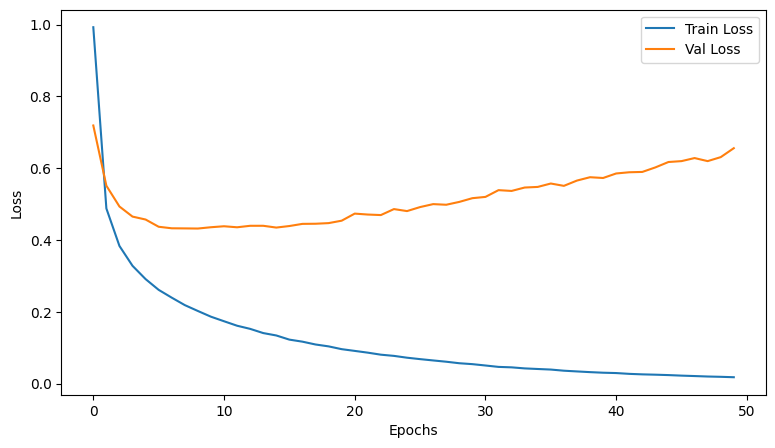

In [10]:
########
#THIS IS Q1 PLOT   
######



train_loader, val_loader = dataset(dataDimention,seed)
model1 = MODEL1()
optimizer = optim.Adam(model1.parameters())
train_losses,val_losses = lossCalculation(model1,train_loader,val_loader,epochsDimention,loss_Funciton,optimizer)

plt.figure(figsize=(20, 5))
# Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


### 2.  Regularisation experiment:  ***12 marks***

Now select a type of regularisation (which may be L2, or dropout) and train your initial model with different amounts of regularisation.

A small amount of regularisation may improve the validation set performance of your overfitted model; too much regularisation may make performance on the validation set worse.

Train your model multiple times, applying different amounts of regularisation, and plot a graoph showing the effect of different amounts of regularisation.

Plot the amount of regularisation along the x axis, and the validation set performance (loss/error-rate) on the y axis.  How does regularisation affect the performance of your initial network, and what is the optimal amount?

the best decay from the function above 0.001
the best VALUE LOSS 0.48117573602497576


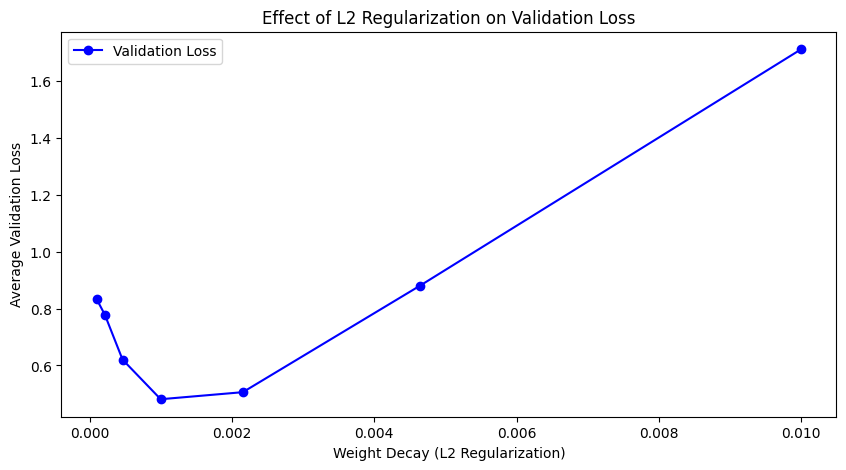

In [11]:
#####
#QTHIS IS Q2 POSS.
#####


train_loader, val_loader = dataset(dataDimention,seed)
modle1 = MODEL1() 
train_losses, val_lo, results, result_val_error_wd, avg_val_losses, best_weight_dacay1,best_value_loss = lossCalculation2(model1,train_loader, val_loader, epochsDimention)

# Plot results
plt.figure(figsize=(10, 5))

# Extract x and y values
weight_decay_values = avg_val_losses.keys()  # X-axis: Weight decay values
avg_validation_lossesM1 = avg_val_losses.values()  # Y-axis: Average validation loss
#print("key ",weight_decay_values)
#print("value ",avg_validation_losses)

#lambda regularization
w = [0.0001000,
0.0002154,
0.0004642,
0.0010000,
0.0021544,
0.0046416,
0.0100000] 


# Plot the graph
plt.plot(w, avg_validation_lossesM1, marker='o', linestyle='-', color='b', label="Validation Loss")


#ADD THE BEST 

print(f"the best decay from the function above {best_weight_dacay1}") 
#print(f"the best weight_decay after plot graph",best_weight_dacay) ### igot th
######
BEST_VALUE_LOSS = best_value_loss #CHANGE
print(f"the best VALUE LOSS {best_value_loss}")    #CHANGE 


# Labels and title
plt.xlabel("Weight Decay (L2 Regularization)")
plt.ylabel("Average Validation Loss")
plt.title("Effect of L2 Regularization on Validation Loss")

# Show legend and grid
plt.legend()

# Display the plot
#plt.show()

## Answer Q2

 
The regualarization is used to prevent overfitting adding penalty to the weight. 
 
In my project I chose the L2 regularization with 7 differetn lambda parameter [0,0.00001,0.0001,0.001,0.01,0.1,1]

All the results of the different test are been plotted on the graph. Unfortunatelly, as that the the results obtained between 0.00001 to 0.001 are all 

very close the graph does not show very well which is the best paramter. however, I printed out the result just above the graphs. Therefore for this 
 
model the best parameter is 0.00001. THIS MAKE SENSE BECAUSE THE GRAPH IN TASK 1 SHOWS THE THE OVERFITTING IN THIS MODEL IS VERY VERY LITTLE.







### 3.  Learning curve experiment:  ***12 marks***

Now train your model (with the amount of regularisation you selected) on different amounts of training data.

Plot the performance (loss/error-rate) of the model on the validation set against the size of the training set.
This is typically best done on a log-log plot.

Describe the approximate relationship between the training set size and loss / error-rate.  Does the network performance appear to improve as some power of the amount of data in the training set?  If so, by what power ?

For example, a very good rate of improvement is for error-rate to be proportional to $\dfrac{1}{\sqrt{n}}$ where $n$ is the training set size.  For your model, the rate of improvement of validation error with training set size may not be as fast as this (or it may, who knows?)  The aim of this exercise is to find out what it actually is.

## Set up model

Set up a Pytorch model (you may find it helpful to keep it simple and fast to train). Train on an intermediate-sized dataset (if you are using MNIST, say 2000 or 4000).


Plot the loss and error rate as a function of training epochs.


dataSize  500
dataSize  1000
dataSize  2000
dataSize  4000
dataSize  8000
dataSize  16000
dataSize  32000
The most powerfull dataSize 32000


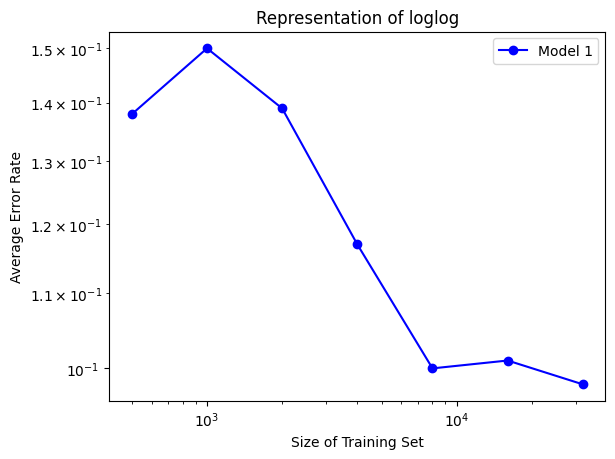

In [24]:
#######
#THIS IS Q3 PLOT ERROR RATE(LOG)
#######
# your code here

array = []
data_Size = [500,1000,2000,4000,8000,16000,32000]
#data_Size = [500,1000]
count = 0
dist = []
model1 = MODEL1()
#print(f"best decay in questiuon 3: {best_weight_dacay}")
for dt in data_Size:
    num_epochs = epochsDimention
    train_loader, val_loader = dataset(dt,seed)
    print("dataSize ",dt)
    train_losses,val_losses,results,result_val_error_wd = calculationErrorRate3(modle1,train_loader,val_loader,num_epochs,best_weight_dacay1)
    tmp=list(result_val_error_wd.values())[0]  # Extracts the first (and only) value
    array.append(tmp) # add ina array list



#weight_decay_values = list(array.keys())  # X-axis: Weight decay values
#avg_validation_losses = array.values()  # Y-axis: Average validation loss
 # Y-axis: Average validation loss

#print("list",array)  # Y-axis: Average validation loss
indMin = np.where(array == np.min(array))[0]  # Get indices of min value
n = indMin[0]
#print("THE Min index",indMin[0])
print("The most powerfull dataSize",data_Size[n])

#evaluating the performance by 1/ np.sqrt(dataSize)
for i in range(len(array)):
    power = 1/np.sqrt(data_Size[i])
    if(power == array[i]):
        print("most powerFull", array[i])
    else:
        #dist.append(np.abs(power - array[i]))
        continue
        #print("no equal: ",power)

# Plot the graph
plt.loglog(data_Size, array, marker='o', linestyle='-', color='b', label="Model 1")


# Labels and title
plt.xlabel("Size of Training Set")
plt.ylabel("Average Error Rate")
plt.title("Representation of loglog")

# Show legend and grid
plt.legend()




## Answer Q3


Describe the approximate relationship between the training set size and loss / error-rate.  Does the network performance appear to improve as some power of the amount of data in the training set?  If so, by what power ?


For example, a very good rate of improvement is for error-rate to be proportional to $\dfrac{1}{\sqrt{n}}$ where $n$ is the training set size.  For your model, the rate of improvement of validation error with training set size may not be as fast as this (or it may, who knows?)  The aim of this exercise is to find out what it actually is.


#######################################################################



the approximate relationship  training set and error rate aim to evaluate different level of overfitting of a model in respect with the the dimention of training set. 

In base of my understarstanding  at a given model the overfitting tand to reduce(our case evaluated by the error rate of tha validation set) at the increases of trainig set(in term of size). 


In my situation the most powerfull is the one with the biggest dataset.
Unfortunally, this can not e confirmed using the relation $\dfrac{1}{\sqrt{n}}$ as i did not find any model which performed good enough to reach an exact match but only a aproximation.  My approximation was calculated  $\dfrac{1}{\sqrt{n}}$ - average error rate.
 


### 4. Second model:   *** 14 marks ***

Devise what you believe to be a better neural network architecture for the problem (e.g. for MNIST you might use a fully-connected network for your initial model, and then try a convolutional net for your second model).

Repeat sections 2 (regularisation experiment), and determine whether it has better validation set performance than the first model, for an intermediate size of training set (e.g. 2000 or 4000 for the MNIST data).

Repeat section 3. Does your model have a different learning curve from the first? Plot the learning curves for the first and second model on the same graph, to compare them. Comment: is there a more rapid reduction of error-rate with training set size for your second model?  

In [13]:
########
#THIS IS Q4 MODEL 2 
#######
#first choice
''''
class MODLE2(nn.Module):
    def __init__(self):
        super(MODLE2, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,6,3), # takes one input channel (greyscale), gives 6 output channes, each from a 3x3 convolutional neuron
            nn.ReLU())
            #nn.Conv2d(6,6,3), # takes 26 x 26 to 24 x 24
            #nn.ReLU(), 
            #nn.MaxPool2d(2,2) )

    def forward(self, x):
        return self.net( x )

#model = SimpleCNN()
#print(model)'
'''

"'\nclass MODLE2(nn.Module):\n    def __init__(self):\n        super(MODLE2, self).__init__()\n        self.net = nn.Sequential(\n            nn.Conv2d(1,6,3), # takes one input channel (greyscale), gives 6 output channes, each from a 3x3 convolutional neuron\n            nn.ReLU())\n            #nn.Conv2d(6,6,3), # takes 26 x 26 to 24 x 24\n            #nn.ReLU(), \n            #nn.MaxPool2d(2,2) )\n\n    def forward(self, x):\n        return self.net( x )\n\n#model = SimpleCNN()\n#print(model)'\n"

In [14]:
#second choice
''''
class MODLE2(nn.Module):
    def __init__(self):
        super(MODLE2, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 6, 3),     # (1, 28, 28) → (6, 26, 26)
            nn.ReLU(),
            nn.Flatten(),           # → (batch_size, 6 * 26 * 26)
            nn.Linear(6 * 26 * 26, 10)
        )

    def forward(self, x):
        return self.net(x)'
'''

"'\nclass MODLE2(nn.Module):\n    def __init__(self):\n        super(MODLE2, self).__init__()\n        self.net = nn.Sequential(\n            nn.Conv2d(1, 6, 3),     # (1, 28, 28) → (6, 26, 26)\n            nn.ReLU(),\n            nn.Flatten(),           # → (batch_size, 6 * 26 * 26)\n            nn.Linear(6 * 26 * 26, 10)\n        )\n\n    def forward(self, x):\n        return self.net(x)'\n"

In [15]:
class MODLE2(nn.Module):
    def __init__(self):
        super(MODLE2, self).__init__()
        self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 128),  # Hidden layer with 128 neurons
        nn.ReLU(),
        nn.Linear(128, 10))  
    
    def forward( self, x ): # computes the forward pass ... this one is particularly simple
        x = self.layers( x )
        return x


In [16]:
n2 = MODLE2()
print(n2)

MODLE2(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [17]:
loss_Funciton = nn.CrossEntropyLoss()

#loss_Funciton = nn.CrossEntropyLoss()
optimizer = optim.Adam(MODLE2().parameters())
#print(optimizer)

In [18]:
#model2

## import thig to do. the funciton must return also the best weigh_decay with the best validation loss.

Repeat sections 2 (regularisation experiment), and determine whether it has better validation set performance than the first model, for an intermediate size of training set (e.g. 2000 or 4000 for the MNIST data).

the best decay from the function above 0.001
the best weight_decay after plot graph 0.001
the best VALUE LOSS 0.310082421164494


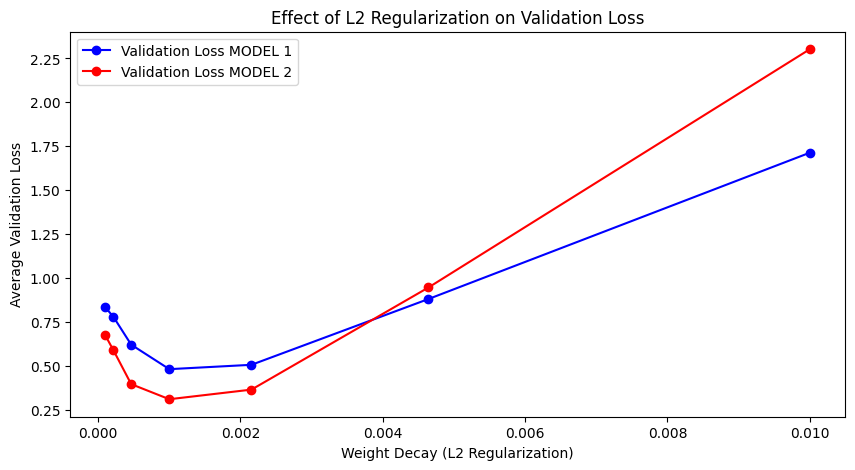

In [19]:
train_loader2, val_loader2 = dataset(dataDimention,seed)
modle2 = MODLE2() 
train_losses2, val_lo2, results2, result_val_error_wd2, avg_val_losses2, best_weight_dacay2,best_value_loss2 = lossCalculation2(modle2,train_loader2, val_loader2, epochsDimention)

# Plot results
plt.figure(figsize=(10, 5))

# Extract x and y values
weight_decay_values2 = avg_val_losses2.keys()  # X-axis: Weight decay values
avg_validation_lossesM2 = avg_val_losses2.values()  # Y-axis: Average validation loss
#print("key ",weight_decay_values)
#print("value ",avg_validation_losses)

#lambda regularizations
w = [0.0001000,
0.0002154,
0.0004642,
0.0010000,
0.0021544,
0.0046416,
0.0100000] 


# Plot the graph
plt.plot(w, avg_validation_lossesM1, marker='o', linestyle='-', color='b', label="Validation Loss MODEL 1")
plt.plot(w, avg_validation_lossesM2, marker='o', linestyle='-', color='r', label="Validation Loss MODEL 2")


#ADD THE BEST 

print(f"the best decay from the function above {best_weight_dacay1}") ### igot th
print(f"the best weight_decay after plot graph",best_weight_dacay2)
######
BEST_VALUE_LOSS2 = best_value_loss2
print(f"the best VALUE LOSS {best_value_loss2}") # CHANGE THIS  


# Labels and title
plt.xlabel("Weight Decay (L2 Regularization)")
plt.ylabel("Average Validation Loss")
plt.title("Effect of L2 Regularization on Validation Loss")

# Show legend and grid
plt.legend()

# Display the plot
#plt.show()

In [20]:
#####
#THIS IS Q4 LOSS PLOT OF MODEL 1 AND MODEL 2
######


###
#THIS FUNTION HAS BEEN COVERED.
#TIHS FUNCTION FOR SOME REASON HAS DIPENDENCY THAT AFFECT THE RESULT OF THE FIRST MODEL.
#
###
'''
model2 = MODLE2()
model1 = MODEL1()
num_epochs = epochsDimention
train_loader, val_loader = dataset(dataDimention,seed)
#train_losses, val_lo, results, result_val_error_wd, avg_val_losses, best_weight_dacay = lossCalculation2MyOne(train_loader, val_loader, num_epochs)
train_lossesM1, val_loM1, resultsM1, result_val_error_wdM1, avg_val_lossesM1, best_weight_dacayM1, best_value_lossM1 = lossCalculation2(model1,train_loader, val_loader, num_epochs)
train_lossesM2, val_loM2, resultsM2, result_val_error_wd, avg_val_lossesM2, best_weight_dacayM2, best_value_lossM2 = lossCalculation2(model2,train_loader, val_loader, num_epochs)
# Plot results
plt.figure(figsize=(10, 5))


# Extract x and y values
weight_decay_valuesM2 = avg_val_lossesM2.keys()  # X-axis: Weight decay values
avg_validation_lossesM2 = avg_val_lossesM2.values()  # Y-axis: Average validation loss

weight_decay_valuesM1 = avg_val_lossesM1.keys()  # X-axis: Weight decay values
avg_validation_lossesM1 = avg_val_lossesM1.values()  # Y-axis: Average validation loss

#print("key ",weight_decay_values)
#print("value ",avg_validation_losses)

#lambda regularization
w = [0.0001000,
0.0002154,
0.0004642,
0.0010000,
0.0021544,
0.0046416,
0.0100000] 


# Plot the graph
plt.plot(w, avg_validation_lossesM2, marker='o', linestyle='-', color='r', label="Validation Loss M2")
plt.plot(w, avg_validation_lossesM1, marker='o', linestyle='-', color='b', label="Validation Loss M1")



#ADD THE BEST 
print(f"the best weight_decay after plot graph M1 {best_weight_dacayM1}, the best weight_decay after plot graph M2 {best_weight_dacayM2}")
print(f"best validatioN loss MODEL 1: {best_value_lossM1} best validation loss MODEL 2: {best_value_lossM2}")
# Use a logarithmic scale for better visualization
#plt.xscale('log')



# Labels and title
plt.xlabel("Weight Decay (L2 Regularization)")
plt.ylabel("Average Validation Loss")
plt.title("Effect of L2 Regularization on Validation Loss")

# Show legend and grid
plt.legend()

# Display the plot
#plt.show()'
'''

'\nmodel2 = MODLE2()\nmodel1 = MODEL1()\nnum_epochs = epochsDimention\ntrain_loader, val_loader = dataset(dataDimention,seed)\n#train_losses, val_lo, results, result_val_error_wd, avg_val_losses, best_weight_dacay = lossCalculation2MyOne(train_loader, val_loader, num_epochs)\ntrain_lossesM1, val_loM1, resultsM1, result_val_error_wdM1, avg_val_lossesM1, best_weight_dacayM1, best_value_lossM1 = lossCalculation2(model1,train_loader, val_loader, num_epochs)\ntrain_lossesM2, val_loM2, resultsM2, result_val_error_wd, avg_val_lossesM2, best_weight_dacayM2, best_value_lossM2 = lossCalculation2(model2,train_loader, val_loader, num_epochs)\n# Plot results\nplt.figure(figsize=(10, 5))\n\n\n# Extract x and y values\nweight_decay_valuesM2 = avg_val_lossesM2.keys()  # X-axis: Weight decay values\navg_validation_lossesM2 = avg_val_lossesM2.values()  # Y-axis: Average validation loss\n\nweight_decay_valuesM1 = avg_val_lossesM1.keys()  # X-axis: Weight decay values\navg_validation_lossesM1 = avg_val_lo


# Answer Q4 part 1

Repeat sections 2 (regularisation experiment), and determine whether it has better validation set performance than the first model, for an intermediate size of training set (e.g. 2000 or 4000 for the MNIST data).

As you can see from the result on my graph the model 2 has an error rate higher than the model 1. This inidcating the the model 2 is more complex theanthe model 1. 


Therefore, ther model 1 is better then the model 2 in respect of this dataset.


## imprtant things to do. plost same gaph  log-log model1 with log-log-model2
Repeat section 3. Does your model have a different learning curve from the first? Plot the learning curves for the first and second model on the same graph, to compare them. Comment: is there a more rapid reduction of error-rate with training set size for your second model? 

MODLE2(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)
dataSize  500
dataSize  1000
dataSize  2000
dataSize  4000
dataSize  8000
dataSize  16000
dataSize  32000
The most powerfull dataSize 32000


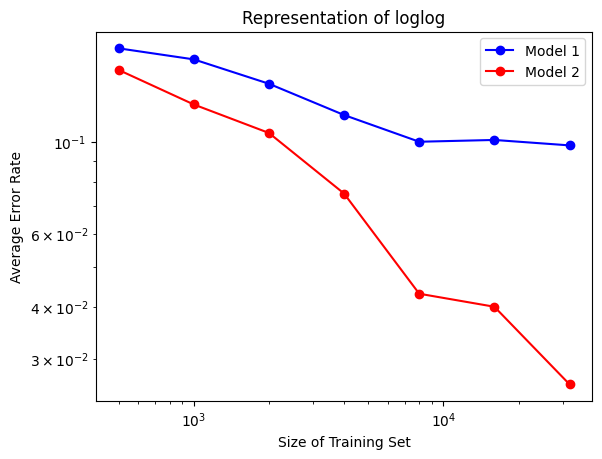

In [21]:

array2 = []
data_Size = [500,1000,2000,4000,8000,16000,32000]
#data_Size = [500,1000]
count = 0
dist = []
model2 = MODLE2()
print(model2)
#print(f"best decay in questiuon 3: {best_weight_dacay}")
for dt in data_Size:
    num_epochs = epochsDimention
    train_loader2, val_loader2 = dataset(dt,seed)
    print("dataSize ",dt)
    train_losses2,val_losses2,results2,result_val_error_wd2 = calculationErrorRate3(modle2,train_loader2,val_loader2,num_epochs,best_weight_dacay2)
    tmp2=list(result_val_error_wd2.values())[0]  # Extracts the first (and only) value
    array2.append(tmp2) # add ina array list



#weight_decay_values = list(array.keys())  # X-axis: Weight decay values
#avg_validation_losses = array.values()  # Y-axis: Average validation loss
 # Y-axis: Average validation loss

#print("list",array)  # Y-axis: Average validation loss
indMin2 = np.where(array2 == np.min(array2))[0]  # Get indices of min value
n = indMin2[0]
#print("THE Min index",indMin[0])
print("The most powerfull dataSize",data_Size[n])

#evaluating the performance by 1/ np.sqrt(dataSize)
for i in range(len(array2)):
    power = 1/np.sqrt(data_Size[i])
    if(power == array2[i]):
        print("most powerFull", array2[i])
    else:
        #dist.append(np.abs(power - array[i]))
        continue
        #print("no equal: ",power)

# Plot the graph
plt.loglog(data_Size, array, marker='o', linestyle='-', color='b', label="Model 1")    
plt.loglog(data_Size, array2, marker='o', linestyle='-', color='r', label="Model 2")


# Labels and title
plt.xlabel("Size of Training Set")
plt.ylabel("Average Error Rate")
plt.title("Representation of loglog")

# Show legend and grid
plt.legend()

In [22]:
######## 
#THIS IS Q4 PLOT ERROR RATE(LOG) MODEL 1 AND MODEL 2
########

###
#THIS FUNTION HAS BEEN COVERED.
#TIHS FUNCTION FOR SOME REASON HAS DIPENDENCY THAT AFFECT THE RESULT OF THE FIRST MODEL.
#
###

'''
#your code here
arrayM1 = []
arrayM2 = []
data_Size = [500,1000,2000,4000,8000,16000,32000]
#data_Size = [500,1000]
count = 0
distM2 = []
distM1 = []
model2 = MODLE2()
model1 = MODEL1()

print(f"BEST DECAY MODEL 1: {best_weight_dacayM1}best decay MODEL 2: {best_weight_dacayM2}")

for dt in data_Size:
    num_epochs = epochsDimention
    train_loader, val_loader = dataset(dt,seed)
    print("dataSize ",dt)
    train_losses1,val_losses1,results1,result_val_error_wd1 = calculationErrorRate3(model1,train_loader,val_loader,num_epochs,best_weight_dacayM1) # model 1
    train_losses1,val_losses1,results1,result_val_error_wd2 = calculationErrorRate3(model2,train_loader,val_loader,num_epochs,best_weight_dacayM2) # model 2
    
    
    tmpM1=list(result_val_error_wd1.values())[0]  # Extracts the first (and only) value
    arrayM1.append(tmpM1) # add ina array list

    tmpM2=list(result_val_error_wd2.values())[0]  # Extracts the first (and only) value
    arrayM2.append(tmpM2) # add ina array list


#print average loss M1 and M2
#print("list M2",arrayM2)  
#print("list M1",arrayM1)

#evaluating the performance by 1/ np.sqrt(dataSize)
#if no find substract the dis-pow and and return the minimum
for i in range(len(arrayM2)):
    power = 1/np.sqrt(data_Size[i])
    if(power == arrayM2[i]):
        print("most powerFull", arrayM2[i])
    else:
        distM2.append(np.abs(power - arrayM2[i]))
        #print("no equal: ",power)


for i in range(len(arrayM1)):
    power = 1/np.sqrt(data_Size[i])
    if(power == arrayM1[i]):
        print("most powerFull", arrayM1[i])
    else:
        #distM1.append(np.abs(power - arrayM1[i]))
        continue
        #print("no equal: ",power)


#extract min best dataseze for model 1
indMinModel1 = np.where(arrayM1 == np.min(arrayM1))[0]  # Get indices of min value
m1 = indMinModel1[0]

#extract min best dataseze for model 1
indMinModel2 = np.where(arrayM2 == np.min(arrayM2))[0]  # Get indices of min value
m2 = indMinModel2[0]
#print("THE Min index",indMin[0])
print(f"The most powerfull dataSize in Model 1: {data_Size[m1]} The most powerfull dataSize in Model : {data_Size[m2]}")


# Plot the graph
plt.loglog(data_Size, arrayM1, marker='o', linestyle='-', color='b', label="Model 1")
plt.loglog(data_Size, arrayM2, marker='o', linestyle='-', color='r', label="Model 2")


# Labels and title
plt.xlabel("Size of Training Set")
plt.ylabel("Average Error Rate")
plt.title("Representation of loglog")

# Show legend and grid
plt.legend()
'''


'\n#your code here\narrayM1 = []\narrayM2 = []\ndata_Size = [500,1000,2000,4000,8000,16000,32000]\n#data_Size = [500,1000]\ncount = 0\ndistM2 = []\ndistM1 = []\nmodel2 = MODLE2()\nmodel1 = MODEL1()\n\nprint(f"BEST DECAY MODEL 1: {best_weight_dacayM1}best decay MODEL 2: {best_weight_dacayM2}")\n\nfor dt in data_Size:\n    num_epochs = epochsDimention\n    train_loader, val_loader = dataset(dt,seed)\n    print("dataSize ",dt)\n    train_losses1,val_losses1,results1,result_val_error_wd1 = calculationErrorRate3(model1,train_loader,val_loader,num_epochs,best_weight_dacayM1) # model 1\n    train_losses1,val_losses1,results1,result_val_error_wd2 = calculationErrorRate3(model2,train_loader,val_loader,num_epochs,best_weight_dacayM2) # model 2\n    \n    \n    tmpM1=list(result_val_error_wd1.values())[0]  # Extracts the first (and only) value\n    arrayM1.append(tmpM1) # add ina array list\n\n    tmpM2=list(result_val_error_wd2.values())[0]  # Extracts the first (and only) value\n    arrayM2.app

# Answer Q4 part 2

Repeat section 3. Does your model have a different learning curve from the first? Plot the learning curves for the first and second model on the same graph, to compare them. Comment: is there a more rapid reduction of error-rate with training set size for your second model? 


After trained the model 1 and model 2 the graph shows thatr the model 1 has a rapid reduce of the error rate than the model 2. 

This is conrfim the model 1 respend mucch better in the of reducing overfitting than the model 2.
